In [1]:
library(GenomicRanges)
library(plyranges)
library(ggplot2)
library(rtracklayer)
library(tibble)
library(readr)

Le chargement a nécessité le package : stats4

Le chargement a nécessité le package : BiocGenerics


Attachement du package : ‘BiocGenerics’


Les objets suivants sont masqués depuis ‘package:stats’:

    IQR, mad, sd, var, xtabs


Les objets suivants sont masqués depuis ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, setdiff, sort,
    table, tapply, union, unique, unsplit, which.max, which.min


Le chargement a nécessité le package : S4Vectors


Attachement du package : ‘S4Vectors’


L'objet suivant est masqué depuis ‘package:utils’:

    findMatches


Les objets suivants sont masqués depuis ‘package:base’:

    expand.grid, I, unname


Le chargement a nécessité le package : IRanges

Le chargement a 

In [2]:
flank_size <- 1e6    # ±1Mb
bin_width <- 10000   # bin width for aggregation

# CTCF and TAD borders in bovine

### The TAD borders

In [3]:
tad_path = "../../CTCF/data/bos_taurus/Bovin-0197.ARS-UCD1.2.mapq_10.10000_norm_custom_boundaries.bed"
tad_borders = import(tad_path)

In [4]:
tad_borders

GRanges object with 6875 ranges and 2 metadata columns:
         seqnames              ranges strand |        name     score
            <Rle>           <IRanges>  <Rle> | <character> <numeric>
     [1]        1       697501-732500      * |      B00046 -0.757498
     [2]        1       825001-835000      * |      B00054 -0.725402
     [3]        1     1115001-1125000      * |      B00083 -0.514388
     [4]        1     1645001-1655000      * |      B00136 -0.918733
     [5]        1     1925001-1935000      * |      B00164 -0.342202
     ...      ...                 ...    ... .         ...       ...
  [6871]        X 134205001-134215000      * |     B253447 -0.395888
  [6872]        X 134905001-134915000      * |     B253517 -0.939332
  [6873]        X 138255001-138265000      * |     B253842 -1.059216
  [6874]        X 138625001-138635000      * |     B253879 -0.172532
  [6875]        X 138795001-138805000      * |     B253896 -0.720985
  -------
  seqinfo: 30 sequences from an unspe

### Constructing windows (size 2*flank_size) centered at each TAD border

In [5]:
tad_windows <- tad_borders %>%
  anchor_center() %>%
  mutate(width = 2 * flank_size)

In [6]:
tad_windows$tad_id <- seq_along(tad_windows)

In [7]:
tad_windows

GRanges object with 6875 ranges and 3 metadata columns:
         seqnames              ranges strand |        name     score    tad_id
            <Rle>           <IRanges>  <Rle> | <character> <numeric> <integer>
     [1]        1     -284999-1715000      * |      B00046 -0.757498         1
     [2]        1     -169999-1830000      * |      B00054 -0.725402         2
     [3]        1      120001-2120000      * |      B00083 -0.514388         3
     [4]        1      650001-2650000      * |      B00136 -0.918733         4
     [5]        1      930001-2930000      * |      B00164 -0.342202         5
     ...      ...                 ...    ... .         ...       ...       ...
  [6871]        X 133210001-135210000      * |     B253447 -0.395888      6871
  [6872]        X 133910001-135910000      * |     B253517 -0.939332      6872
  [6873]        X 137260001-139260000      * |     B253842 -1.059216      6873
  [6874]        X 137630001-139630000      * |     B253879 -0.172532      6

### Tiling the each window with bins of size (bin_width)

In [8]:
tad_bins <- tad_windows %>%
  tile_ranges(width = bin_width) %>%
  mutate(rel_pos = (start + end) / 2 - start(tad_windows)[partition] - flank_size)

In [9]:
tad_bins

GRanges object with 1375000 ranges and 2 metadata columns:
            seqnames              ranges strand | partition   rel_pos
               <Rle>           <IRanges>  <Rle> | <integer> <numeric>
        [1]        1     -284999--275000      * |         1   -995000
        [2]        1     -274999--265000      * |         1   -985000
        [3]        1     -264999--255000      * |         1   -975000
        [4]        1     -254999--245000      * |         1   -965000
        [5]        1     -244999--235000      * |         1   -955000
        ...      ...                 ...    ... .       ...       ...
  [1374996]        X 139750001-139760000      * |      6875    955000
  [1374997]        X 139760001-139770000      * |      6875    965000
  [1374998]        X 139770001-139780000      * |      6875    975000
  [1374999]        X 139780001-139790000      * |      6875    985000
  [1375000]        X 139790001-139800000      * |      6875    995000
  -------
  seqinfo: 30 sequenc

### A bed file with the CTCF predictions

In [ ]:
ctcf_path="../../CTCF/data/bos_taurus/fimo_CTCF.bed"
ctcf_sites=import(ctcf_path)

Fo reach TAD bin :
  - count the corresponding overlapping CTCF prediction and 
  - group by TAD and by relative position of the TAB bin to the TAD border
  - count the number of CTCF within each (TAB, bin) group
  - compute the mean, over all TADs, of CTCF counts for each bin

In [ ]:
bin_enrichment <- tad_bins %>%
  join_overlap_left(ctcf_sites) %>%
  group_by(partition, rel_pos) %>%
  summarise(ctcf_count = n()) %>%
  as_tibble() %>%
  group_by(rel_pos) %>%
  summarise(mean_ctcf = mean(ctcf_count))

In [11]:
library(readr)
#bin_enrichment %>% write_tsv("bovine_enrichment.tsv")
bin_enrichment = read_tsv("bovine_enrichment.tsv")

Rows: 200 Columns: 2
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
dbl (2): rel_pos, mean_ctcf

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


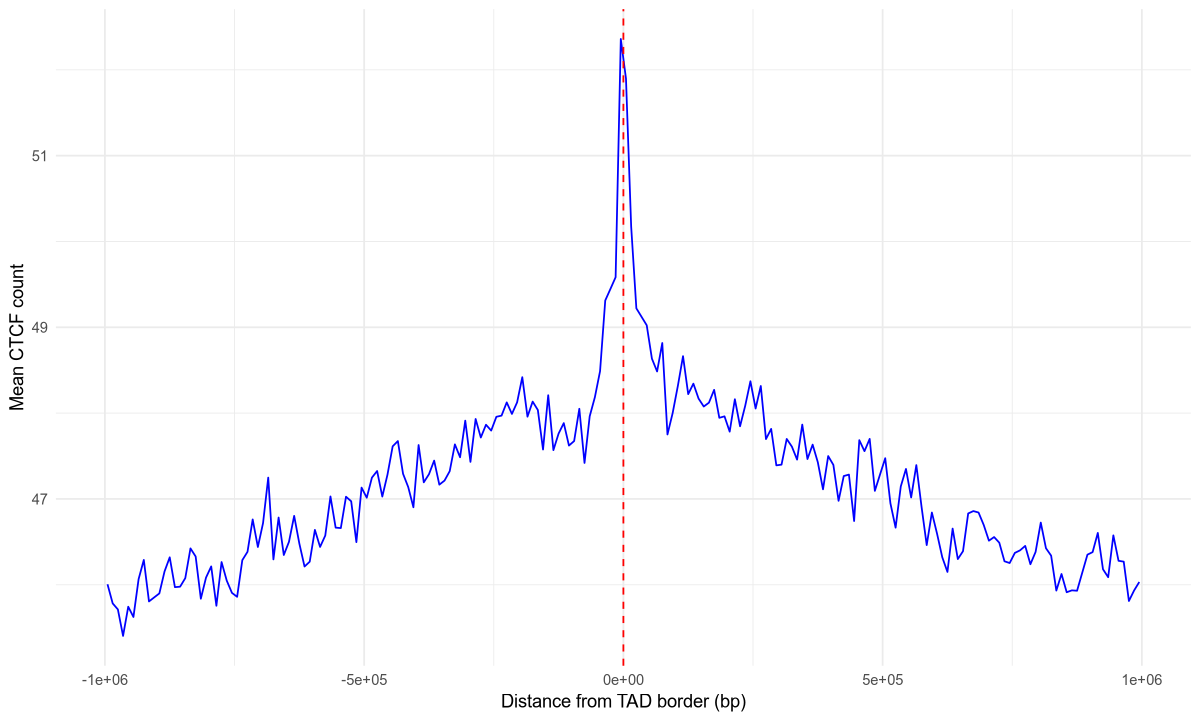

In [12]:
options(repr.plot.width=10, repr.plot.height=6)
ggplot(bin_enrichment, aes(x = rel_pos, y = mean_ctcf)) +
  geom_line(color="blue") +
  geom_vline(xintercept = 0, linetype = "dashed", color = "red") +
  labs(x = "Distance from TAD border (bp)", y = "Mean CTCF count") +
  theme_minimal()

## CTCF and TAD borders in human

In [13]:
#tad_path = "../../data/4DNFI9GMP2J8_10kb_TADs_boundaries.bed"
tad_path = "../../data/tadmap/TAD_boundaries.bed"
tad_borders = import(tad_path)

In [14]:
tad_borders

GRanges object with 60682 ranges and 2 metadata columns:
          seqnames            ranges strand |        name     score
             <Rle>         <IRanges>  <Rle> | <character> <numeric>
      [1]     chr1     827751-829250      * |      B00056 -0.179266
      [2]     chr1     869501-870500      * |      B00097 -0.119838
      [3]     chr1     904501-905500      * |      B00132 -0.265485
      [4]     chr1     923501-924500      * |      B00151  0.418674
      [5]     chr1     941501-942500      * |      B00169  0.269417
      ...      ...               ...    ... .         ...       ...
  [60678]     chrY 22288501-22289500      * |    B2759871  0.165453
  [60679]     chrY 22308501-22309500      * |    B2759891  0.255591
  [60680]     chrY 26639501-26640500      * |    B2760273 -0.165655
  [60681]     chrY 56827501-56828500      * |    B2760339 -0.316077
  [60682]     chrY 56851501-56852500      * |    B2760363 -0.273736
  -------
  seqinfo: 24 sequences from an unspecified genom

In [15]:
tad_windows <- tad_borders %>%
  anchor_center() %>%
  mutate(width = 2 * flank_size)

In [16]:
tad_windows$tad_id <- seq_along(tad_windows)

In [17]:
tad_windows

GRanges object with 60682 ranges and 3 metadata columns:
          seqnames            ranges strand |        name     score    tad_id
             <Rle>         <IRanges>  <Rle> | <character> <numeric> <integer>
      [1]     chr1   -171499-1828500      * |      B00056 -0.179266         1
      [2]     chr1   -129999-1870000      * |      B00097 -0.119838         2
      [3]     chr1    -94999-1905000      * |      B00132 -0.265485         3
      [4]     chr1    -75999-1924000      * |      B00151  0.418674         4
      [5]     chr1    -57999-1942000      * |      B00169  0.269417         5
      ...      ...               ...    ... .         ...       ...       ...
  [60678]     chrY 21289001-23289000      * |    B2759871  0.165453     60678
  [60679]     chrY 21309001-23309000      * |    B2759891  0.255591     60679
  [60680]     chrY 25640001-27640000      * |    B2760273 -0.165655     60680
  [60681]     chrY 55828001-57828000      * |    B2760339 -0.316077     60681
  [6068

In [18]:
tad_bins <- tad_windows %>%
  tile_ranges(width = bin_width) %>%
  mutate(rel_pos = (start + end) / 2 - start(tad_windows)[partition] - flank_size)

In [19]:
tad_bins

GRanges object with 12136400 ranges and 2 metadata columns:
             seqnames            ranges strand | partition   rel_pos
                <Rle>         <IRanges>  <Rle> | <integer> <numeric>
         [1]     chr1   -171499--161500      * |         1   -995000
         [2]     chr1   -161499--151500      * |         1   -985000
         [3]     chr1   -151499--141500      * |         1   -975000
         [4]     chr1   -141499--131500      * |         1   -965000
         [5]     chr1   -131499--121500      * |         1   -955000
         ...      ...               ...    ... .       ...       ...
  [12136396]     chrY 57802001-57812000      * |     60682    955000
  [12136397]     chrY 57812001-57822000      * |     60682    965000
  [12136398]     chrY 57822001-57832000      * |     60682    975000
  [12136399]     chrY 57832001-57842000      * |     60682    985000
  [12136400]     chrY 57842001-57852000      * |     60682    995000
  -------
  seqinfo: 24 sequences from an u

In [ ]:
ctcf_path="../../CTCF/data/homo_sapiens/CTCF_hg38_all_reformat.bed"
ctcf_path="../../CTCF/data/homo_sapiens/CTCF_hg38_reformat.bed"
ctcf_sites=import(ctcf_path)

In [ ]:
bin_enrichment <- tad_bins %>%
  join_overlap_left(ctcf_sites) %>%
  group_by(partition, rel_pos) %>%
  summarise(ctcf_count = n()) %>%
  as_tibble() %>%
  group_by(rel_pos) %>%
  summarise(mean_ctcf = mean(ctcf_count))

In [ ]:
#bin_enrichment %>% write_tsv("human_enrichment.tsv")
bin_enrichment = read_tsv("human_enrichment.tsv")

In [ ]:
ggplot(bin_enrichment, aes(x = rel_pos, y = mean_ctcf)) +
  geom_line(color="blue") +
  geom_vline(xintercept = 0, linetype = "dashed", color = "red") +
  ggtitle("CTCF enrichment at TAD border in human" ) +
  labs(x = "Distance from TAD border (bp)", y = "Mean CTCF count") +
  theme_minimal()